In [1]:
#!/usr/bin/env python3

# Menyesuaikan path agar dapat mengimpor modul dari direktori utama (induk)
# tanpa mengubah struktur direktori proyek
import sys
sys.path.append('..')

# Mengimpor file module untuk melakukan sync semua file
# pada direktori utama (induk)
import module

Memastikan mendukung pemrosesan menggunakan CUDA (GPU)

In [6]:
import cv2


print(hasattr(cv2, "cuda")) 
print(cv2.cuda.getCudaEnabledDeviceCount() > 0)

True
True


In [2]:
from enum import Enum


class FlowStrategy(Enum):

    # Melakukan komputasi penuh pada wajah
    FLOW_FULLFACE = "flow_fullface"

    # Melakukan komputasi hanya pada area wajah tertentu
    # yang telah dipilih sesuai dengan ROI (Region of Interest)
    FLOW_ROI_BASE = "flow_roi_base"

In [26]:
# Bagian ini merujuk pada implementasi sebelumnya untuk ekstraksi optical flow menggunakan TV-L1
# Ref: https://github.com/face-decoder/optical-flow/blob/b4a631384063b6df18fa3fb70d477d99263d2e85/src/optical_flow/modules/tvl1.py

import cv2
import numpy as np
from src.image.modules import Image


class TVL1:

    # Image instance untuk pemrosesan gambar
    image: Image = None

    def __init__(self, fast_mode: bool = True):
        
        self.image = Image()
        
        self.flow = None
        
        self.use_cuda = False

        # Deteksi cuda saat pertama kali inisialisasi untuk menentukan apakah akan menggunakan GPU atau CPU
        # Jika tidak ada dukungan CUDA, akan menggunakan CPU dengan OpenCV OptFlow TV-L1
        # Jika ada dukungan CUDA, akan menggunakan OpenCV CUDA TV-L1 untuk performa yang lebih baik
        has_cuda = hasattr(cv2, "cuda") and cv2.cuda.getCudaEnabledDeviceCount() > 0
        has_cuda_tvl1 = has_cuda and hasattr(cv2.cuda, "OpticalFlowDual_TVL1_create")

        if has_cuda_tvl1:
            self.use_cuda = True
            self.tvl1 = cv2.cuda.OpticalFlowDual_TVL1_create()
            self.gpumat_prev = cv2.cuda_GpuMat()
            self.gpumat_next = cv2.cuda_GpuMat()
            self.gpumat_flow = cv2.cuda_GpuMat()
        else:
            # Fallback aman ke CPU
            self.tvl1 = cv2.optflow.DualTVL1OpticalFlow_create()

        # Parameter dasar untuk TV-L1
        # Ini adalah nilai default yang dapat disesuaikan sesuai kebutuhan
        self.tvl1.setLambda(0.15)
        self.tvl1.setTheta(0.3)
        self.tvl1.setTau(0.25)

        # Penyesuaian parameter untuk improve performa dengan mengorbankan akurasi
        # Jika fast_mode diaktifkan, kita akan mengurangi jumlah iterasi dan skala
        # Ini akan sedikit mempercepat komputasi tetapi mungkin mengurangi akurasi optical flow
        if fast_mode:
            if hasattr(self.tvl1, "setScalesNumber"):
                self.tvl1.setScalesNumber(3)
            if hasattr(self.tvl1, "setWarpingsNumber"):
                self.tvl1.setWarpingsNumber(2)
            if hasattr(self.tvl1, "setInnerIterations"):
                self.tvl1.setInnerIterations(20)
            if hasattr(self.tvl1, "setOuterIterations"):
                self.tvl1.setOuterIterations(5)
            if hasattr(self.tvl1, "setMedianFiltering"):
                self.tvl1.setMedianFiltering(1)


    def compute(self, prev: np.ndarray, next: np.ndarray, download: bool = True):
        """
        Menghitung optical flow antara dua frame menggunakan algoritma TV-L1.

        Args:
            prev (numpy.ndarray): Frame sebelum.
            next (numpy.ndarray): Frame saat ini.
            download (bool): Jika True hasil di-download ke CPU (numpy array).
                             Jika False (GPU mode), kembalikan GpuMat.

        Returns:
            numpy.ndarray | cv2.cuda_GpuMat: Optical flow yang dihitung.
        """
        if prev is None or next is None:
            raise ValueError("Input frame is None.")
        if prev.shape != next.shape:
            raise ValueError("Input frames must have the same dimensions.")

        # Jika input bukan grayscale, konversi ke grayscale
        # Memastikan input adalah 2D (grayscale)
        gray_prev = prev if prev.ndim == 2 else self.image.grayscale(prev)
        gray_next = next if next.ndim == 2 else self.image.grayscale(next)

        # Pastikan tipe data adalah uint8 untuk kompatibilitas dengan OpenCV
        if gray_prev.dtype != np.uint8:
            gray_prev = gray_prev.astype(np.uint8, copy=False)
        if gray_next.dtype != np.uint8:
            gray_next = gray_next.astype(np.uint8, copy=False)

        # Pastikan array adalah contiguous untuk performa yang lebih baik
        # OpenCV membutuhkan array yang contiguous untuk operasi GPU
        gray_prev = np.ascontiguousarray(gray_prev)
        gray_next = np.ascontiguousarray(gray_next)

        if self.use_cuda:
            self.gpumat_prev.upload(gray_prev)
            self.gpumat_next.upload(gray_next)

            # Reuse output buffer, tidak perlu release tiap frame
            self.gpumat_flow = self.tvl1.calc(self.gpumat_prev, self.gpumat_next, self.gpumat_flow)
            flow = self.gpumat_flow.download() if download else self.gpumat_flow
        else:
            flow = self.tvl1.calc(gray_prev, gray_next, None)

        self.flow = flow
        return flow


    def close(self):
        if self.use_cuda:
            self.gpumat_prev.release()
            self.gpumat_next.release()
            self.gpumat_flow.release()

Membandingkan performance pada saat pemrosesan gambar fullface dan juga roi based

In [27]:
import os
from pathlib import Path


BASE_DIRECTORY=os.path.join(Path.home(), "datasets", "primary-converted")

TARGET_FILE = os.path.join(BASE_DIRECTORY, "8-12-2025", "aaisyah_nursalsabiil_ni_patriarti_1765168488512", "q1", "answer_1_15d591ce-051a-47f2-ac38-367c1e6189c7_sec.avi")

In [28]:
import cv2
import time

cap = cv2.VideoCapture(TARGET_FILE)

ret1, frame1 = cap.read()
ret2, frame2 = cap.read()
cap.release()

tvl1 = TVL1(fast_mode=True)

_ = tvl1.compute(frame1, frame2)

N = 600
t0 = time.perf_counter()
for _ in range(N):
    _ = tvl1.compute(frame1, frame2)
t1 = time.perf_counter()

print("avg per call:", (t1 - t0) / N, "s")

tvl1.close()


avg per call: 0.015421863153333106 s


Melakukan komparasi dengan model TV-L1 lama secara komputasi

In [29]:
import time
from src.optical_flow.modules import TVL1 as PrevTVL1

def benchmark(model, frame1, frame2, n=600, label="", download=False):
    model.compute(frame1, frame2)

    t0 = time.perf_counter()
    for _ in range(n):
        if (download):
            model.compute(frame1, frame2, download=False)
        else:
            model.compute(frame1, frame2)
    avg = (time.perf_counter() - t0) / n

    print(f"avg per call ({label}): {avg:.6f} s")
    return avg


tvl1_prev = PrevTVL1()
benchmark(tvl1_prev, frame1, frame2, label="prev")


tvl1 = TVL1(fast_mode=True)
benchmark(tvl1, frame1, frame2, label="new", download=True)

tvl1.close()


avg per call (prev): 0.015350 s
avg per call (new): 0.015357 s


Mengurangi kompleksitas dengan resize ukuran gambar dan juga menerapkan batching

In [ ]:
# Benchmark dengan memperkecil ukuran frame melalui proses resize

import cv2
import time


tvl1 = TVL1(fast_mode=True)

N = 600

resized_full_face_prev = cv2.resize(frame1, (320, 240), interpolation=cv2.INTER_AREA)
resized_full_face_next = cv2.resize(frame2, (320, 240), interpolation=cv2.INTER_AREA)

_ = tvl1.compute(resized_full_face_prev, resized_full_face_next, download=False)

t0 = time.perf_counter()

for _ in range(N):
    _ = tvl1.compute(resized_full_face_prev, resized_full_face_next, download=False)

t1 = time.perf_counter()

avg_full = (t1 - t0) / N
print(f"Image full resized (320x240) avg per call: {avg_full}")

tvl1.close()

Image full resized (320x240) avg per call: 0.006825154778334763


In [ ]:
# Benchmarking optical flow performance dengan fokus pada area wajah
# Memotong area wajah dari frame untuk memfokuskan komputasi optical flow pada area utama

import cv2
import time
from src.face.modules import FaceLandmark


tvl1 = TVL1(fast_mode=True)

face_landmark = FaceLandmark()

N = 600


prev_face_landmarks = face_landmark.detect(frame1)
next_face_landmarks = face_landmark.detect(frame2)

face_size = (240, 240)
prev_face = face_landmark.crop(image=frame1,
                               landmarks=prev_face_landmarks,
                               margin=0.05,
                               output_size=face_size)

next_face = face_landmark.crop(image=frame2,
                               landmarks=next_face_landmarks,
                               margin=0.05,
                               output_size=face_size)

_ = tvl1.compute(prev_face, next_face, download=False)

t0 = time.perf_counter()
for _ in range(N):
    _ = tvl1.compute(prev_face, next_face, download=False)
t1 = time.perf_counter()

avg_face = (t1 - t0) / N
print(f"Image with face area focus avg per call: {avg_face:.6f} s")

tvl1.close()


W0000 00:00:1771069786.477492   33320 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1771069786.482488   33321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1771069786.492550   33333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Image with face area focus avg per call: 0.009427 s


W0000 00:00:1771070352.479905   33899 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1771070352.485148   33905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1771070352.496028   33903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


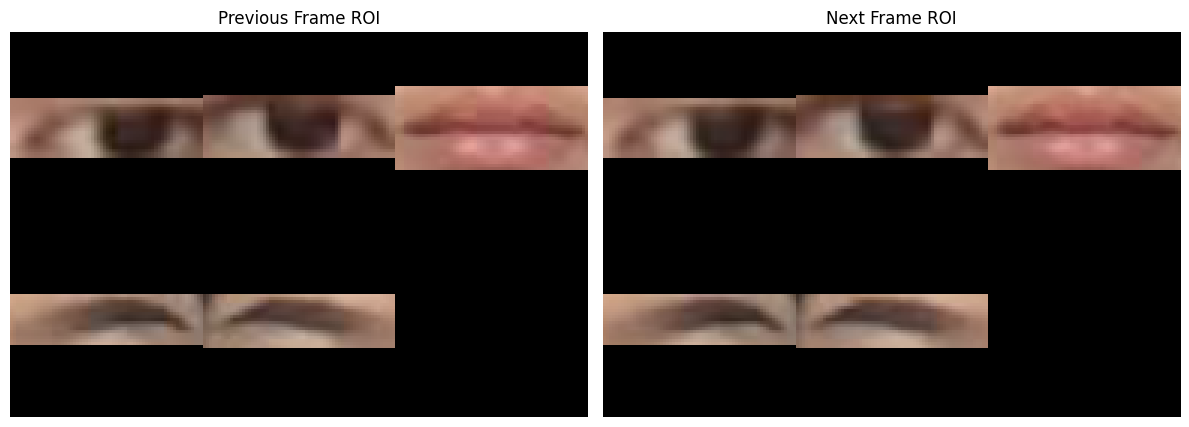

Image with ROI focus avg per call: 0.005247 s


In [ ]:
# Benchmarking optical flow performance dengan fokus pada region of interest (ROI) pada wajah
# Menggunakan landmark wajah untuk menentukan area ROI yang akan diproses

import cv2
import math
import time
import matplotlib.pyplot as plt
from src.face.modules import FaceLandmark, FaceRoiPoints


face_landmark = FaceLandmark()

# Mendefinisikan ukuran-ukuran area yang diambil
roi_defs = [
    frozenset(FaceRoiPoints.LEFT_EYE_POINTS),
    frozenset(FaceRoiPoints.RIGHT_EYE_POINTS),
    frozenset(FaceRoiPoints.LIPS_POINTS),
    frozenset(FaceRoiPoints.LEFT_EYEBROW_POINTS),
    frozenset(FaceRoiPoints.RIGHT_EYEBROW_POINTS),
]

# Ekstraksi titik-titik landmark berdasarkan frame yang dimiliki
prev_face_landmarks = face_landmark.detect(frame1)
next_face_landmarks = face_landmark.detect(frame2)

# Menentukan ukuran canvas untuk menggabungkan keseluruhan ROI
tile_size = (64, 64)
tile_w, tile_h = tile_size
cols = 3
rows = math.ceil(len(roi_defs) / cols)

canvas_prev = np.zeros((rows * tile_h, cols * tile_w, 3), dtype=np.uint8)

for i, roi_points in enumerate(roi_defs):
    roi_img_prev, _ = face_landmark.crop_roi(image=frame1,
                                             landmark_result=prev_face_landmarks,
                                             roi_points=roi_points,
                                             margin=0.05,
                                             target_size=tile_size)

    r = i // cols
    c = i % cols
    y1, y2 = r * tile_h, (r + 1) * tile_h
    x1, x2 = c * tile_w, (c + 1) * tile_w

    canvas_prev[y1:y2, x1:x2] = roi_img_prev


canvas_next = np.zeros((rows * tile_h, cols * tile_w, 3), dtype=np.uint8)

for i, roi_points in enumerate(roi_defs):
    roi_img_next, _ = face_landmark.crop_roi(image=frame2,
                                             landmark_result=prev_face_landmarks,
                                             roi_points=roi_points,
                                             margin=0.05,
                                             target_size=tile_size)

    r = i // cols
    c = i % cols
    y1, y2 = r * tile_h, (r + 1) * tile_h
    x1, x2 = c * tile_w, (c + 1) * tile_w
    canvas_next[y1:y2, x1:x2] = roi_img_next


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv2.cvtColor(canvas_prev, cv2.COLOR_BGR2RGB))
ax[0].set_title("Previous Frame ROI")
ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(canvas_next, cv2.COLOR_BGR2RGB))
ax[1].set_title("Next Frame ROI")
ax[1].axis("off")
plt.tight_layout()
plt.show()

_ = tvl1.compute(canvas_prev, canvas_next, download=False)

t0 = time.perf_counter()
for _ in range(N):
    _ = tvl1.compute(canvas_prev, canvas_next, download=False)
t1 = time.perf_counter()

avg_roi_canvas = (t1 - t0) / N
print(f"Image with ROI focus avg per call: {avg_roi_canvas:.6f} s")

tvl1.close()